MCMC: Markov Chain Monte Carlo. The purpose of MCMC algorithms are to use Bayesian statistics to obtain a sequence of random samples of the probability distribution for the parameters you want to determine.

What does this mean? Say you want to fit a model to some data. Bayes' theorem states that the conditional probability of A given B is

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

In our case, we want to determine the probability distribution of parameters (A) for the model given a collection of data (B). That is, we want to determine $P(A|B)$, or the 'posterior', in the above equation.

$P(B|A)$ is called the 'likelihood,' or the probability that a given set of parameters can give rise to the observed data.

$P(A)$ is called the 'prior' for the parameters, which basically indicates that probability distribution of the parameters before we consider the data. For example, if we know a parameter is going to be between 0 and 1 and if we assume there's an equal likelihood of any value in that range could be the correct one, our prior would be a uniform distribution between 0 and 1. Other common priors are Gaussian distributions, power laws, etc

$P(B)$ is called the 'evidence.' Since this is constant, it can be ignored unless you're comparing different models, which I won't cover here.

So the basic idea is that we want to get a collection of sample of points from $P(A|B)$ (a 'chain') for a given model and collection of data and use this distribution to estimate the parameters and uncertainties.

How do we do this? The prototypical MCMC algorithm is Metropolis-Hastings. Metropolis-Hastings uses a guided random walk which follows the following procedure:

1. Initialize: pick a starting point in parameter space. You can do this e.g. at random by drawing from the parameter priors.

2. Calculate: Calculate the 'acceptance ratio,' $\alpha$, which is how probable the candidate point is with respect to the current point in parameter space.

3. Accept or reject: Generate a random uniform number on [0,1]. If $u \leq \alpha$, accept the candidate point, if $u \gt \alpha$, reject the candidate point. If the candidate point is accepted, it becomes the new current point. If it is rejected, another candidate point is selected.

4. Keep doing steps 2 and 3 over and over and over until you have a sample of the posterior distribution.

There are a ton of other algorithms out there that are good for different kinds of situations (e.g. high degeneracy, lots of parameters, etc). But a lot of them are variations of this basic idea.

There are also a ton of python MCMC modules, but we'll use pymc cuz it's pretty easy to pick up and use. I may add some other examples in here at some point.

Example time! Let's fit a Gaussian.  Let's assume we have a Gaussian with a true $\mu=80$ and $\sigma^2=20$. We will first create some data and then try to recover the true values of $\mu$ and $\sigma$ by fitting with MCMC.

In [2]:
import random
import numpy as np
from pymc import *
import math
import matplotlib.pyplot as plt

# Generate the data and plot it
TRUE_MEAN = 80
TRUE_VARIANCE = 20
data = np.array([random.gauss(TRUE_MEAN, math.sqrt(TRUE_VARIANCE)) for i in range(0, 10000)])

plt.hist(data, bins=50)

(array([   1.,    0.,    3.,    2.,    3.,    7.,    7.,   12.,   20.,
          26.,   48.,   49.,   95.,  105.,  152.,  201.,  225.,  315.,
         330.,  409.,  475.,  530.,  545.,  588.,  631.,  585.,  575.,
         545.,  576.,  514.,  474.,  440.,  337.,  281.,  252.,  157.,
         136.,   98.,   80.,   62.,   44.,   22.,   17.,   11.,    6.,
           3.,    4.,    1.,    0.,    1.]),
 array([ 62.48110423,  63.17165574,  63.86220725,  64.55275876,
         65.24331027,  65.93386178,  66.62441329,  67.31496479,
         68.0055163 ,  68.69606781,  69.38661932,  70.07717083,
         70.76772234,  71.45827385,  72.14882536,  72.83937687,
         73.52992838,  74.22047989,  74.9110314 ,  75.60158291,
         76.29213442,  76.98268593,  77.67323744,  78.36378895,
         79.05434046,  79.74489197,  80.43544348,  81.12599499,
         81.8165465 ,  82.50709801,  83.19764952,  83.88820103,
         84.57875254,  85.26930405,  85.95985555,  86.65040706,
         87.34095857,  8

In [3]:
# Assume uniform priors for the mean and precision
mean = Uniform('mean', lower=min(data), upper=max(data))
precision = Uniform('precision', lower=0.00001, upper=1.0)

#Assume the underlying distribution is Gaussian
sample_distribution = Normal('sample_distribution', mu=mean, tau=precision, observed=True, value=data)

In [4]:
import pprint #pretty-print. you don't actually need this but it makes the output look nice

model = pymc.Model([mean,precision,sample_distribution])

# Run sampling for 40000 iterations, with a burn-in of 20000 iterations and thinning for every 10 iterations.
M = MCMC(model)
M.sample(iter=40000, burn=20000, thin=10)

#pprint.pprint(M.stats()) #M.stats is how you access the statistics for the chain

mean_chain = M.trace('mean')[:] #M.trace is how you access the full MC chain excluding 
precision_chain = M.trace('precision')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 11.2 sec

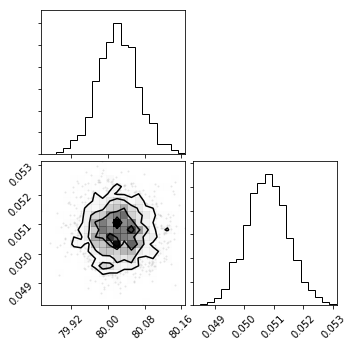

In [5]:
import corner #corner is a very useful module for plotting MC chains

figure = corner.corner(np.transpose([mean_chain,precision_chain]))

In [13]:
#if you wanna calculate the statistics yourself, you can use np.percentile and calculate 1 sigma, 2 sigma, 3 sigma countours

#calculate the mean of the chain
fitmean = np.percentile(mean_chain,50)
fitprecision = np.percentile(precision_chain,50)

#calculate 1 sigma 
mean1sighigh = np.percentile(mean_chain,68.27)
mean1siglow = np.percentile(mean_chain,31.73)

precision1sighigh = np.percentile(precision_chain,68.27)
precision1siglow = np.percentile(precision_chain,31.73)

print fitmean
print fitprecision


80.021490847
0.0507663013157
